# Algorithm

# Level-2 Sea Ice Drift (SID) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIED algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceDrift_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceDrift_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceDrift_ATBD/_images/CIMR_L2_Sea_Ice_Drift_Flow_Diagram.png" width="100%"/>

## Settings

Imports and general settings

In [1]:
%load_ext cython

In [2]:
# Paths

# Getting the path of the notebook (NOTE: not totally safe)

# The paths assume that there is an umbrella CIMR directory (of any name) containing SeaIceDrift_ATBD_v2/ ,
# the CIMR Tools/ directory, and a directory data/L1B/ containing the L1B data, and data/conc/ containing
# a concentration file
import os
cpath = os.path.join(os.getcwd(), '../..')
algpath = os.path.join(cpath, 'SeaIceDrift_ATBD_v2/algorithm/src_sied')
toolpath = os.path.join(cpath, 'Tools')
l1bpath = os.path.join(cpath, 'data/L1B')
griddeffile = os.path.join(cpath, 'Overall_ATBD/etc/grids_py.def')

# Processing directories
procpath = os.path.join(cpath, 'data/processing')
driftpath = os.path.join(cpath, 'data/icedrift')
logpath = os.path.join(cpath, 'data/logs')
figpath = os.path.join(cpath, 'data/figs')


In [3]:
# Imports

from importlib import reload
import sys
import shutil
import warnings
import math
import numpy as np
import numpy.ma as ma
import xarray as xr
#from netCDF4 import Dataset
from matplotlib import pylab as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
#import cmocean
#import cartopy
import cartopy.crs as ccrs
from pyresample import parse_area_file
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Local modules contain software code that implement the SIED algorithm
if algpath not in sys.path:
    sys.path.insert(0, algpath)
from icedrift_wrapper import icedrift_wrapper
#from process_ice_mask import process_ice_mask
#from cp_and_date_change_iceconc import cp_and_date_change_iceconc

# Prototype re-gridding toolbox to handle the L1B input
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)
#from tools import io_handler as io
#from tools import collocation as coll
from tools import l2_format as l2

In [4]:
# Plot settings

import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

cmap = cm.viridis
#cmapland = matplotlib.colors.ListedColormap(['none', 'grey'])

gridtype = 'ease'
gridin = '{}-ease2-050'
gridout = '{}-ease2-250'
# Some region parameters hard-coded to show only the relevant region
# Overall shape of input grid (4320, 4320)
#sl = (1050, 1400, 1050, 1400)
slo = (200, 290, 200, 290)

# EASE plotting region
lon_min = -15
lon_max = 95
lat_min = 74
lat_max = 90

# Settings for gridlines
lon_step = 10
lat_step = 5

## Parametrize the run

User-set parameters for the running of the whole notebook. Note that here a helper script is used to copy a starter ice concentration file from the MET Norway thredds server and change the dates in this. The date changes are required due to the sample input file having a date in the future (2028).

In [5]:
hemi = 'nh'
#algos = {'KU': {'channels':('tb19v', 'tb19h'), 'target_band':'KU'},
#         'KA': {'channels':('tb37v', 'tb37h'), 'target_band':'KA'}}
#wbs = list(algos.keys())
#fwdbck = ['fw', 'bk']
#polarisation = {'V': 0, 'H': 1}
#pols = list(polarisation.keys())

test_card = "radiometric"
if test_card == "geometric":
    # DEVALGO's simulated geometric test card
    l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card == "radiometric":
    # DEVALGO's simulated radiometric test card
    l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'

#dt = datetime.strptime('20230420T103323', '%Y%m%dT%H%M%S')

l1bfile = os.path.join(l1bpath, l1bfn)

pdate = datetime.strptime('20280110', '%Y%m%d')
tdate = pdate - relativedelta(years=10)
qdate = pdate + timedelta(days=1)

# Icemask data and output locations
#icemaskinputdir = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/{:%Y}/{:%m}'.format(tdate, tdate)
#icemaskinputfile = 'ice_conc_{}_ease2-250_cdr-v3p0_{:%Y%m%d}1200.nc'.format(hemi, tdate)
#icemaskinput = cp_and_date_change_iceconc(os.path.join(icemaskinputdir, icemaskinputfile), concpath, pdate)

algo_version = '0.1'

plotfigs = True

## Step 1: Cross-correlation algorithm to find ice drift


For the Continuous Maximum Cross-Correlation algorithm, two brightness temperature gridded files, enhanced by the Laplacian algorithm and with different timestamps, are required. The algorithm matches features between these images on a fractional pixel grid.

The steps of the cross-correlation algorithm are:
1. Determination of which pixels should be included in the cross-correlation, excluding land and ocean pixels.
2. Fractional pixel cross-correlation simultaneously on the gridded swaths - forward/back scans, V and H polarisations, K and Ka channels.
3. Correction of erroneous vectors using the nearest neighbour method and creation of status flags.

Currently the C code has limited memory for channels, so the Ka-band forward and backward scans with V and H polarisations are accepted by the code. It should be possible to add K-band later. 

In addition, the forward and backward scans are treated here as having the same timestamp, later it can be refined to include the 7-minute delay between these two.

In [6]:
# Copying the files with new names, to interface with the C-code

gridname = gridin.format(hemi)
chanstr = 'tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk'

dsname = os.path.join(procpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, pdate))
dsname2 = os.path.join(procpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, qdate))

newname1 = 'tc_wght_cimr-cimr_{}_{}_{}12.nc'.format(chanstr, gridin.format(hemi), datetime.strftime(pdate, '%Y%m%d'))
newname2 = 'tc_wght_cimr-cimr_{}_{}_{}12.nc'.format(chanstr, gridin.format(hemi), datetime.strftime(qdate, '%Y%m%d'))
shutil.copyfile(dsname, os.path.join(os.path.dirname(dsname), newname1))
shutil.copyfile(dsname2, os.path.join(os.path.dirname(dsname), newname2))

'/home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc'

In [7]:
%load_ext autoreload
%autoreload

from icedrift_wrapper import icedrift_wrapper
rad = 100.
rad_neigh = 150.
# Original rad=75. rad_neigh=125.
# Worked with rad=100. rad_neigh=150.
# rad = 25. rad_neigh=150. has lots of corrected by neighbours, but a better field
chan_list = ['tb37hfw_lap', 'tb37vfw_lap', 'tb37hbk_lap', 'tb37vbk_lap']
# Suppress the proj4 string warning on this
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    idrift = icedrift_wrapper(pdate, qdate, procpath, procpath, driftpath, os.path.join(logpath, 'cmcc-test.log'),
                          'cimr-cimr', gridin.format(hemi), chan_list, rad, rad_neigh, 
                          area_out=gridout.format(hemi))



Daily maps found (cimr-cimr):

	Day 1 : /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011012.nc 

	Day 2 : /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc 



Calling the C core code...
 
 LOGMSG [icedrift_solve_core 2024-06-28 12:59]:
	Start processing.
 
	Log file is </home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/logs/cmcc-test.log>
	Radius for pattern #0 is 100.0km
	Radius for pattern #1 is 50.0km
	Maximum drift distance is 38.88km


## Step 2: Format L2 file and write to disk

The output icedrift file is processed and written, with metadata.

In [8]:
driftx = ma.asarray(idrift['drift_x'])
driftx.mask = driftx < -1e9
drifty = ma.asarray(idrift['drift_y'])
drifty.mask = drifty < -1e9
flag = ma.asarray(idrift['flag'])

dms = driftx.shape
ddx = driftx.reshape(1, dms[0], dms[1])
ddy = drifty.reshape(1, dms[0], dms[1])
stdx = ma.asarray(idrift['std_x'])
stdx.mask = stdx < -1e9
stdx = stdx.reshape(1, dms[0], dms[1])
stdy = ma.asarray(idrift['std_y'])
stdy.mask = stdy < -1e9
stdy = stdy.reshape(1, dms[0], dms[1])
dflag = ma.asarray(idrift['flag'])
dflag = flag.reshape(1, dms[0], dms[1])


In [9]:
reload(l2)

# Output grid
og = gridout.format(hemi)
out_area_def = parse_area_file(griddeffile, og)[0]
olons, olats = out_area_def.get_lonlats()

# Get a template L2 format (netCDF/CF) from the Tools module
ds_l2 = l2.get_CIMR_L2_template('grid', geo_def=out_area_def, add_time=[pdate.timestamp()])

# Create a DataArray for x and y icedrift from the template
da_dx = xr.DataArray(ddx, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='driftX')
da_dx.attrs['long_name'] = 'x-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_dx.attrs['standard_name'] = 'x_component_sea_ice_drift'
da_dx.attrs['units'] = 'km'
da_dx.attrs['coverage_content_type'] = 'physicalMeasurement'
da_dx.attrs['auxiliary_variables'] = 'status_flag'
da_dy = xr.DataArray(ddy, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='driftY')
da_dy.attrs['long_name'] = 'y-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_dy.attrs['standard_name'] = 'y_component_sea_ice_drift'
da_dy.attrs['units'] = 'km'
da_dy.attrs['coverage_content_type'] = 'physicalMeasurement'
da_dy.attrs['auxiliary_variables'] = 'status_flag'

# Create a DataArray for std x and y icedrift from the template
da_stddx = xr.DataArray(stdx, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='stdX')
da_stddx.attrs['long_name'] = 'Standard deviation of x-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_stddx.attrs['units'] = 'km'
da_stddx.attrs['coverage_content_type'] = 'auxiliaryInformation'
da_stddx.attrs['auxiliary_variables'] = 'status_flag'
da_stddy = xr.DataArray(stdy, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='stdY')
da_stddy.attrs['long_name'] = 'Standard deviation of y-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_stddy.attrs['units'] = 'km'
da_stddy.attrs['coverage_content_type'] = 'auxiliaryInformation'
da_stddy.attrs['auxiliary_variables'] = 'status_flag'

# Create a DataArray for the status flag from the template
da_flag = xr.DataArray(dflag, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='status_flag')
da_flag.attrs['long_name'] = 'Status flag of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_flag.attrs['units'] = 1
da_flag.attrs['coverage_content_type'] = 'auxiliaryInformation'

# Add the data arrays to the ds_l2 object
ds_l2 = ds_l2.merge(da_dx)
ds_l2 = ds_l2.merge(da_dy)
ds_l2 = ds_l2.merge(da_stddx)
ds_l2 = ds_l2.merge(da_stddy)
ds_l2 = ds_l2.merge(da_flag)

# Customize the global attributes
ds_l2.attrs['title'] = 'CIMR L2 Sea Ice Drift'
ds_l2.attrs['summary'] = 'Sea Ice Drift computed with the prototype algorithm developed in the ESA CIMR DEVALGO study. The algorithm combines Ku and Ka imagery channels. The product file contains the sea ice drift, its uncertainties, and processing flags.'
ds_l2.attrs['l1b_file'] = os.path.basename(l1bfile)
ds_l2.attrs['algorithm_version'] = algo_version

ds_l2.attrs['creator_name'] = 'Emily Down and Thomas Lavergne'
ds_l2.attrs['creator_email'] = 'emilyjd@met.no'
ds_l2.attrs['institution'] = 'Norwegian Meteorological Institute'

# Remove the 'template' variable (we don't need it anymore)
ds_l2 = ds_l2.drop_vars('template')

# Write to file
l2_n = 'cimr_devalgo_l2_sid_{}_{}.nc'.format(og, test_card)
l2_n = os.path.join(driftpath, l2_n)
ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC')
print(l2_n)

/home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/icedrift/cimr_devalgo_l2_sid_nh-ease2-250_radiometric.nc


## Step 3: Plotting

Here an example plot of the icedrift output is made.

In [10]:
def crs_create(gridtype, hemi):

    # Define grid based on region
    if gridtype == 'polstere':
        if hemi == 'nh':
            plot_proj4_params = {'proj': 'stere',
                                 'lat_0': 90.,
                                 'lat_ts' : 70.,
                                 'lon_0': -45.0,
                                 'a': 6378273,
                                 'b': 6356889.44891}
            plot_globe = ccrs.Globe(semimajor_axis=plot_proj4_params['a'],
                                    semiminor_axis=plot_proj4_params['b'])
            plot_crs = ccrs.NorthPolarStereo(
                central_longitude=plot_proj4_params['lon_0'], globe=plot_globe)
        else:
            plot_proj4_params = {'proj': 'stere',
                                 'lat_0': -90.,
                                 'lat_ts' : -70.,
                                 'lon_0': 0.,
                                 'a': 6378273,
                                 'b': 6356889.44891}
            plot_globe = ccrs.Globe(semimajor_axis=plot_proj4_params['a'],
                                    semiminor_axis=plot_proj4_params['b'])
            plot_crs = ccrs.SouthPolarStereo(
                central_longitude=plot_proj4_params['lon_0'], globe=plot_globe)
    elif gridtype == 'ease':
        if hemi == 'nh':
            plot_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                                      central_latitude=90,
                                                      false_easting=0,
                                                      false_northing=0)
        else:
            plot_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                                      central_latitude=-90,
                                                      false_easting=0,
                                                      false_northing=0)
    else:
        raise ValueError("Unrecognised region {}".format(region))

    return(plot_crs)

In [11]:
def flag_arrow_col(flag, procfmt=False):

    if procfmt:
        flgfmt = 'proc'
    else:
        flgfmt = 'final'

    # Use colours from https://sashamaps.net/docs/resources/20-colors/
    fblack = '#000000'
    fmaroon = '#800000'
    forange = '#f58231'
    fnavy = '#000075'
    fblue = '#4363d8'
    flavender = '#dcbeff'
    fgrey = '#a9a9a9'

    fbrown = '#9A6324'
    fteal = '#469990'
    fgreen = '#3cb44b'
    fcyan = '#42d4f4'
    fmagenta = '#f032e6'

    fred = '#e6194B'
    fpurple = '#911eb4'

    flag_cols = {}
    flag_cols['final'] = {30: fblack,   # Nominal quality
                          20: fbrown,   # Single-sensor, with smaller pattern
                                        # block
                          21: forange,  # Single-sensor, with neighbours as
                                        # constraint
                          22: fmaroon,  # Interpolated
                          23: fcyan,    # Gap filling in wind drift
                          24: fteal,    # Vector replaced by wind drift
                          25: fnavy,    # Blended satellite and wind drift
}
    flag_cols['proc'] = {0: fblack,     # Nominal quality
                         16: fpurple,   # Interpolated
                         13: fred,      # Single-sensor, with neighbours as
                                        # constraint
                         17: fgreen,    # Single-sensor, with smaller
                                        # pattern block
}

    default = 'black'
    if flag in flag_cols[flgfmt].keys():
        return flag_cols[flgfmt][flag]
    else:
        return default

In [12]:
scale = 1000.
pc = ccrs.PlateCarree()

def plotdriftarr(ax, plot_crs, data_crs, lon, lat, dx, dy, sflag, driftflags=True):
    
    for i in range(dx.size):
        try:
            x0, y0 = plot_crs.transform_point(lon[~dx.mask][i], lat[~dx.mask][i], src_crs=pc)
            adx = dx[~dx.mask][i]
            ady = dy[~dy.mask][i]
            len_arrow = math.sqrt(adx**2 + ady**2)

            # Calculate the endpoints and therefore dx, dy components of the drift arrows in the plot
            # coordinate system
            xorig, yorig = data_crs.transform_point(lon[~dx.mask][i], lat[~dx.mask][i], src_crs=pc)
            xarr = xorig + adx
            yarr = yorig + ady
            x1, y1 = plot_crs.transform_point(xarr, yarr, src_crs=data_crs)
            pdx = (x1 - x0) * scale
            pdy = (y1 - y0) * scale
            
            # Set the colour of the drift arrows if this should be
            # done with status flags
            if driftflags:
                myflag = sflag[~dx.mask][i]
                ar_col = flag_arrow_col(myflag, procfmt=True)
            else:
                ar_col = 'black'

            # If the arrow is too small, mark a symbol instead
            if len_arrow * scale < 2000:
                plt.plot(x0, y0, 's', color=ar_col, markersize=1)
            else:
                head_length = 0.3 * len_arrow * scale
                plt.arrow(x0, y0, pdx, pdy, color=ar_col,
                    shape='full', head_length=head_length,
                    head_width=15000,
                    fill=True, length_includes_head=True,
                    width=4000)

        except:
            pass # Outside the range of points

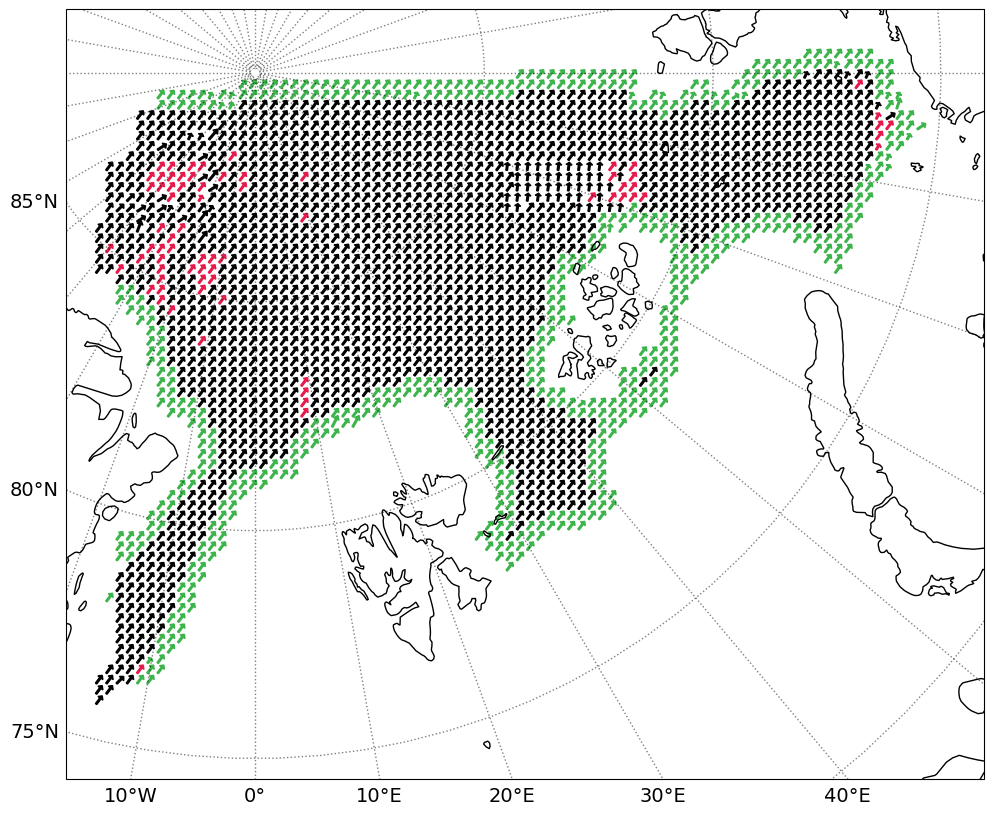

FLAG VALUES 
Unprocessed pixel                              -1
Nominal                                        0
Outside image border                           1
Close to image border                          2
Pixel center over land                         3
No ice                                         4
Close to coast or edge                         5
Close to missing pixel                         6
Close to unprocessed pixel                     7
Icedrift optimisation failed                   8
Icedrift failed                                9
Icedrift with low correlation                  10
Icedrift calculation took too long             11
Icedrift calculation refused by neighbours     12
Icedrift calculation corrected by neighbours   13
Icedrift no average                            14
Icedrift masked due to summer season           15
Icedrift multi-oi interpolation                16
Icedrift calcuated with smaller pattern        17
Icedrift masked due to NWP                     

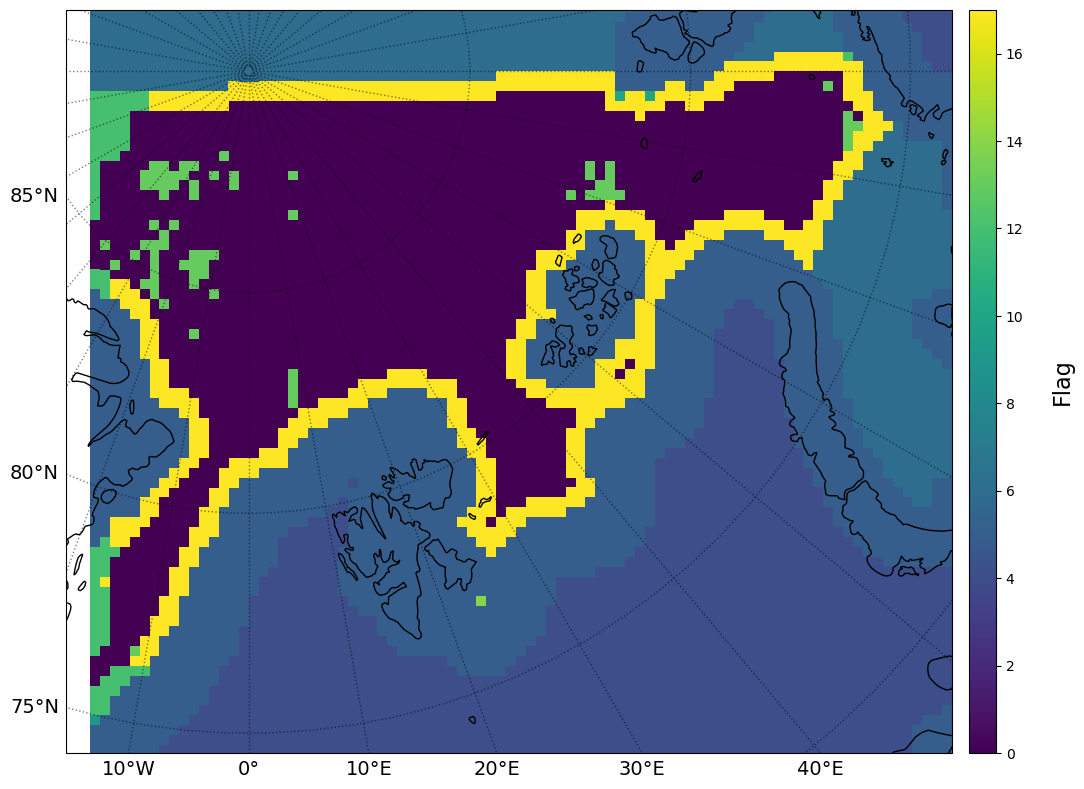

In [13]:
# Plotting the ice drift with arrows
# Modified from the SeaSurfaceTemperature_ATBD_v2, by Emy Alerskans

# Drift data
xydata = {'dx': driftx, 'dy': drifty}
limminxy = np.nanmin([np.nanmin(a) for a in xydata.values()])
limminxy = limminxy - 0.1 * abs(limminxy)
limmaxxy = np.nanmax([np.nanmax(a) for a in xydata.values()])
limmaxxy = limmaxxy + 0.1 * abs(limmaxxy)
limminflag = np.nanmin(flag)
limmaxflag = np.nanmax(flag)

# Output lat/lons
og = gridout.format(hemi)
out_area_def = parse_area_file(griddeffile, og)[0]
olons, olats = out_area_def.get_lonlats()

# Coordinate reference systems
plot_crs = crs_create(gridtype, hemi)
pc = ccrs.PlateCarree()
if 'ease' in gridout:
    data_crs = crs_create('ease', hemi)
else:
    data_crs = crs_create('polstere', hemi)

# Plotting drift
fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(1, 1, 1, projection=plot_crs)

plotdriftarr(ax, plot_crs, data_crs, olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
             driftx[slo[0]:slo[1], slo[2]:slo[3]], drifty[slo[0]:slo[1], slo[2]:slo[3]],
             flag[slo[0]:slo[1], slo[2]:slo[3]], driftflags=True)

ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}    

if plotfigs:
    plt.savefig(os.path.join(figpath, 'drift_rad{}.png'.format(int(rad))))
plt.show()

# Status flags
fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(1, 1, 1, projection=plot_crs)
im = ax.pcolormesh(olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
                    flag[:][slo[0]:slo[1], slo[2]:slo[3]], transform=pc,
                    cmap=cmap, vmin=limminflag, vmax=limmaxflag)
ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
        
# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad="2%", axes_class=plt.Axes)
cb = fig.colorbar(im, cax=cax)
cb.set_label(label="Flag", fontsize=16, labelpad=20.0)
cb.ax.set_ylim(limminflag, limmaxflag)
        
print("\
FLAG VALUES \n\
Unprocessed pixel                              -1\n\
Nominal                                        0\n\
Outside image border                           1\n\
Close to image border                          2\n\
Pixel center over land                         3\n\
No ice                                         4\n\
Close to coast or edge                         5\n\
Close to missing pixel                         6\n\
Close to unprocessed pixel                     7\n\
Icedrift optimisation failed                   8\n\
Icedrift failed                                9\n\
Icedrift with low correlation                  10\n\
Icedrift calculation took too long             11\n\
Icedrift calculation refused by neighbours     12\n\
Icedrift calculation corrected by neighbours   13\n\
Icedrift no average                            14\n\
Icedrift masked due to summer season           15\n\
Icedrift multi-oi interpolation                16\n\
Icedrift calcuated with smaller pattern        17\n\
Icedrift masked due to NWP                     18\n\
")